# Predicting NYC Taxi Fares with Small Dataset

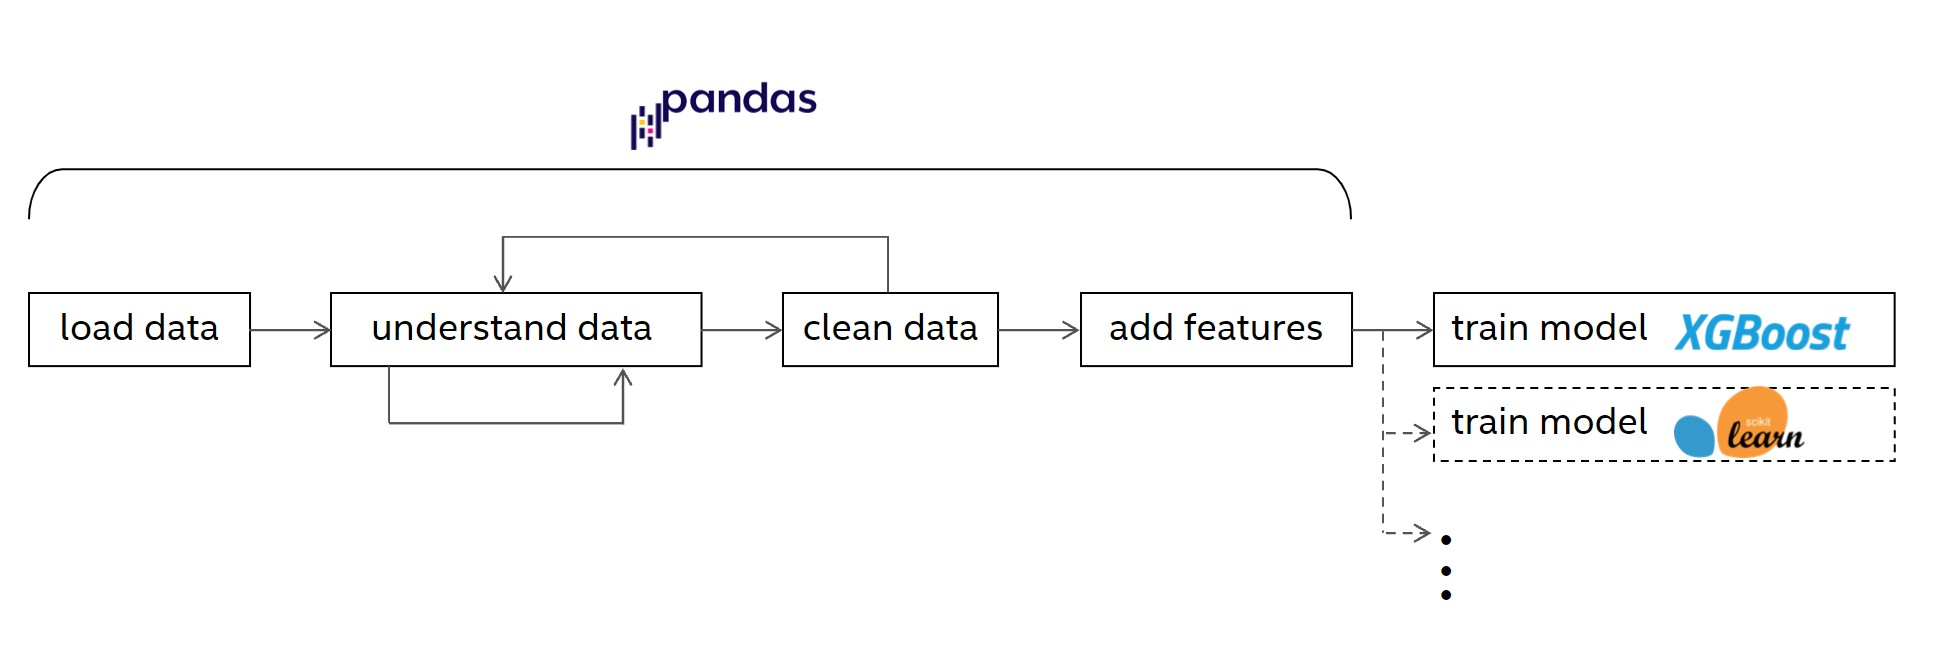

This is a notebook originally written for Rapids but converted to plain Pandas.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import socket, time
import pandas as pd
import xgboost as xgb

#To install Holoviews and hvplot
#conda install -c conda-forge holoviews
#conda install -c pyviz hvplot
import holoviews as hv
from holoviews import opts
import numpy as np
import hvplot.pandas
hv.extension('bokeh')

# Inspecting the Data

We'll use Pandas to load and parse one CSV file from each year into a DataFrame. It makes it 3 files overall.

In [ ]:
base_path = '/yellow-taxi/'

df_2014 = pd.read_csv(base_path+'2014/yellow_tripdata_2014-01.csv', parse_dates=[' pickup_datetime', ' dropoff_datetime'])
df_2014.dtypes

# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns. The 2015 CSVs have `tpep_pickup_datetime` and `tpep_dropoff_datetime`, which are the same columns. One year has `rate_code`, and another `RateCodeID`.

Also, some CSV files have column names with extraneous spaces in them.

Worst of all, starting in the July 2016 CSVs, pickup & dropoff latitude and longitude data were replaced by location IDs, making the second half of the year useless to us.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [ ]:
#Dictionary of required columns and their datatypes
must_haves = {
     'pickup_datetime': 'datetime64[s]',
     'dropoff_datetime': 'datetime64[s]',
     'passenger_count': 'int32',
     'trip_distance': 'float32',
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'rate_code': 'int32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'fare_amount': 'float32'
    }

In [ ]:
def clean(ddf, must_haves):
    # replace the extraneous spaces in column names and lower the font type
    tmp = {col:col.strip().lower() for col in list(ddf.columns)}
    ddf = ddf.rename(columns=tmp)

    ddf = ddf.rename(columns={
        'tpep_pickup_datetime': 'pickup_datetime',
        'tpep_dropoff_datetime': 'dropoff_datetime',
        'ratecodeid': 'rate_code'
    })
    
    for col in ddf.columns:
        if col not in must_haves:
            ddf = ddf.drop(columns=col)
            continue
        if ddf[col].dtype == 'object':
            ddf[col] = ddf[col].fillna('-1')
    
    return ddf

<b> NOTE: </b>We will realize that some of 2015 data has column name as `RateCodeID` and others have `RatecodeID`. When we rename the columns in the clean function, it internally doesn't pass meta while calling map_partitions(). This leads to the error of column name mismatch in the returned data. For this reason, we will call the clean function with map_partition and pass the meta to it. Here is the link to the bug created for that: https://github.com/rapidsai/cudf/issues/5413 

In [ ]:
df_2014 = clean(df_2014, must_haves)

We still have 2015 and the first half of 2016's data to read and clean. Let's increase our dataset.

In [ ]:
df_2015 = pd.read_csv(base_path+'2015/yellow_tripdata_2015-01.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [ ]:
df_2015 = clean(df_2015, must_haves)

# Handling 2016's Mid-Year Schema Change

In 2016, only January - June CSVs have the columns we need. If we try to read base_path+2016/yellow_*.csv, Dask will not appreciate having differing schemas in the same DataFrame.

Instead, we'll need to create a list of the valid months and read them independently.

In [ ]:
months = [str(x).rjust(2, '0') for x in range(1, 7)]
valid_files = [base_path+'2016/yellow_tripdata_2016-'+month+'.csv' for month in months]

In [ ]:
#read & clean 2016 data and concat all DFs
df_2016 = clean(pd.read_csv(valid_files[0], parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']), must_haves)

In [ ]:
#concatenate multiple DataFrames into one bigger one
taxi_df = pd.concat([df_2014, df_2015, df_2016])

In [ ]:
# taxi_df = taxi_df.persist()
taxi_df.dtypes

In [ ]:
taxi_df.shape

## Exploratory Data Analysis (EDA)

Here, we are checking out if there are any non-sensical records and outliers, and in such case, we need to remove them from the dataset.

In [ ]:
# check out if there is any negative total trip time
taxi_df[taxi_df.dropoff_datetime <= taxi_df.pickup_datetime].head()

In [ ]:
# check out if there is any abnormal data where trip distance is short, but the fare is very high.
taxi_df[(taxi_df.trip_distance < 10) & (taxi_df.fare_amount > 300)].head()

In [ ]:
# check out if there is any abnormal data where trip distance is long, but the fare is very low.
taxi_df[(taxi_df.trip_distance > 50) & (taxi_df.fare_amount < 50)].head()

In [ ]:
#Using only 2016-01 data for visuals.
#taxi_df_cdf = clean(cudf.read_csv(valid_files[0]),must_haves)

#Using entire 2016 data for visualization
taxi_df_cdf = taxi_df

The plot below visualizes the histogram of trip_distance and we can see some abnormal trip_distance values for some records. Taking this and also the NYC map coordinates into consideration, we will only select records where tripdistance < 500 miles.

In [ ]:
%%time
#Histogram using cupy and Holoviews
# frequencies, edges = cupy.histogram(x=cupy.array(taxi_df_cdf["trip_distance"]) , bins=20)
# hist = hv.Histogram((np.array(edges.tolist()), np.array(frequencies.tolist())))

#Histogram using hvplot
hist = taxi_df_cdf.hvplot.hist("trip_distance", bins=20, bin_range=(0, 10))

#Customizing the plot
hist.opts(xlabel="trip distance (miles)",ylabel="count",color="green",width=900, height=400)

Similarly, the plot below visualizes the histogram of fare_amount and we can see some abnormal fare_amount values for some records. Taking this and also the NYC map coordinates into consideration, we will only select records where fare_amount < 500$.

In [ ]:
%%time
#Histogram using cupy and Holoviews
# frequencies, edges = cupy.histogram(x=cupy.array(taxi_df_cdf["fare_amount"]) , bins=20)
# hist = hv.Histogram((np.array(edges.tolist()), np.array(frequencies.tolist())))

#Histogram using hvplot
hist = taxi_df_cdf.hvplot.hist("fare_amount", bins=20, bin_range=(0, 50))

#Customizing the plot
hist.opts(xlabel="fare amount ($)",ylabel="count",color="green",width=900, height=400)

In [ ]:
%%time
# Plot the number of passengers per trip. We'll remove the records where passenger_count > 5.
# Plotting using Holoviews
#bar = hv.Bars(taxi_df_cdf.groupby("passenger_count").size().to_frame().rename(columns={0:"count"}))

# Plotting using hvplot
df_bar = taxi_df_cdf.groupby("passenger_count").size().to_frame().rename(columns={0:"count"}).reset_index()
bar = df_bar.hvplot.bar(x="passenger_count",y="count")

#Customizing the plot
bar.opts(color="green",width=900, height=400)

EDA visuals and additional analysis yield the filter logic below.

In [ ]:
taxi_df.shape

In [ ]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 1 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42',
    'trip_distance > 0 and trip_distance < 500',
    'not (trip_distance > 50 and fare_amount < 50)',
    'not (trip_distance < 10 and fare_amount > 300)',
    'not dropoff_datetime <= pickup_datetime'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

In [ ]:
# reset_index and drop index column
taxi_df = taxi_df.reset_index(drop=True)

# Adding Interesting Features

We'll use a Euclidean Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [ ]:
## add features
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day

#calculate the time difference between dropoff and pickup.
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int64') - taxi_df['pickup_datetime'].astype('int64')

taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude']//.01*.01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude']//.01*.01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude']//.01*.01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude']//.01*.01

taxi_df = taxi_df.drop('pickup_datetime', axis=1)
taxi_df = taxi_df.drop('dropoff_datetime', axis=1)

In [ ]:
dlon = taxi_df['dropoff_longitude'] - taxi_df['pickup_longitude']
dlat = taxi_df['dropoff_latitude'] - taxi_df['pickup_latitude']
taxi_df['e_distance'] = dlon * dlon + dlat * dlat

In [ ]:
taxi_df.dtypes

In [ ]:
taxi_df.shape

# Pick a Training Set

Let's imagine you're making a trip to New York on the 25th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

In [ ]:
#since we calculated the h_distance let's drop the trip_distance column, and then do model training with XGB.
taxi_df = taxi_df.drop('trip_distance', axis=1)

In [ ]:
# this is the original data partition for train and test sets.
X_train = taxi_df.query('day < 25')

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']]
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# Train the XGBoost Regression Model

The wall time output below indicates how long it took to train an XGBoost model over the training set.

In [ ]:
X_train.shape

In [ ]:
X_train.dtypes

In [ ]:
Y_train.shape

In [ ]:
dtrain = xgb.DMatrix(X_train, Y_train)

## Time to Train our XGBoost Model!

In [ ]:
%%time

trained_model = xgb.train({
    'learning_rate': 0.3,
    'max_depth': 8,
    'objective': 'reg:squarederror',
    'subsample': 0.6,
    'gamma': 1,
    'silent': True,
    'verbose_eval': True,
    'tree_method':'hist'
    },
    dtrain,
    num_boost_round=100, evals=[(dtrain, 'train')])

In [ ]:
ax = xgb.plot_importance(trained_model, height=0.8, max_num_features=10, importance_type="gain")
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
ax.set_xlabel('importance')
plt.show()

# How Good is Our Model?

Now that we have a trained model, we need to test it with the 25% of records we held out.

In [ ]:
X_test = taxi_df.query('day >= 25')

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']]

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

# display test set size
X_test.shape

## Calculate Prediction

In [ ]:
# generate predictions on the test set
booster = trained_model
prediction = pd.Series(booster.predict(xgb.DMatrix(X_test)))
prediction.head()

In [ ]:
# prediction = prediction.map_partitions(lambda part: cudf.Series(part)).reset_index(drop=True)
actual = Y_test['fare_amount'].reset_index(drop=True)

In [ ]:
prediction.head()

In [ ]:
actual.head()

In [ ]:
# Calculate RMSE
squared_error = ((prediction-actual)**2)

# compute the actual RMSE over the full test set
np.sqrt(squared_error.mean())

# Scikit-Learn Part

## Normalize data

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_x = MinMaxScaler()
scaler_y = StandardScaler()

In [ ]:
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

In [ ]:
scaler_y.fit(Y_train.to_numpy().reshape(-1, 1))
Y_train = scaler_y.transform(Y_train.to_numpy().reshape(-1, 1)).ravel()
Y_test = scaler_y.transform(Y_test.to_numpy().reshape(-1, 1)).ravel()

## Train Ridge regression model without  Intel® Extension for Scikit-learn*

In [ ]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
%%time
model_r_s = Ridge(random_state=123)
model_r_s.fit(X_train, Y_train)

## Train Ridge regression model with  Intel® Extension for Scikit-learn*

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
%%time
model_r_p = Ridge(random_state=123)
model_r_p.fit(X_train, Y_train)

## Let's look at RMSE metric of models

In [ ]:
y_pred_p = model_r_p.predict(X_test)
y_pred_s = model_r_s.predict(X_test)

mse_r_p = mean_squared_error(Y_test, y_pred_p)
mse_r_s = mean_squared_error(Y_test, y_pred_s)

print(f'RMSE of patched Ridge: {np.sqrt(mse_r_p)}')
print(f'RMSE of unpatched Ridge: {np.sqrt(mse_r_s)}')

As we can see the model with Intel® Extension for Scikit-learn * learns much faster and has the same rmse.